## Predictive Modeling

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap

# Define columns
numerical_cols = ['TotalPremium', 'TotalClaims', 'SumInsured', 'CalculatedPremiumPerTerm', 'VehicleAge', 'Cylinders', 'cubiccapacity', 'kilowatts', 'NumberOfDoors', 'mmcode']
categorical_cols = ['Province', 'Gender', 'VehicleType', 'CoverType', 'make', 'Model', 'bodytype']

# Load data
df = pd.read_csv('../data/MachineLearningRating_v3_v2.csv', low_memory=False)

### Data Preparation

In [58]:
# Calculate VehicleAge
df['VehicleAge'] = pd.to_datetime('2025-06-18').year - pd.to_numeric(df['RegistrationYear'], errors='coerce')

# Replace empty strings and 'Not specified' with NaN
df = df.replace('', np.nan)
df = df.replace('Not specified', np.nan)

# Convert numerical columns to numeric, coercing errors to NaN
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute missing values in all numerical columns with a robust fallback
for col in numerical_cols:
    non_nan_values = df[col][~df[col].isna()]
    median_val = non_nan_values.median() if not non_nan_values.empty else np.nan
    if np.isnan(median_val):
        print(f"Warning: No valid median for column {col}, using 0 as fallback.")
        median_val = 0
    df[col] = df[col].fillna(median_val)

# Impute categorical columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Add HasClaim
df['HasClaim'] = df['TotalClaims'] > 0

# Encode categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Impute NaN in df_encoded (post-encoding) for numeric columns with robust fallback
for col in df_encoded.columns:
    if df_encoded[col].dtype in ['int64', 'float64']:
        non_nan_values = df_encoded[col][~df_encoded[col].isna()]
        median_val = non_nan_values.median() if not non_nan_values.empty else np.nan
        if np.isnan(median_val):
            print(f"Warning: No valid median for column {col} in df_encoded, using 0 as fallback.")
            median_val = 0
        df_encoded[col] = df_encoded[col].fillna(median_val)

### Train-Split Testing and Modeling

Model Performance:
                            RMSE        R2
Linear Regression  34937.180529  0.241033
Random Forest      37624.214252  0.119799
XGBoost            40234.069012 -0.006549


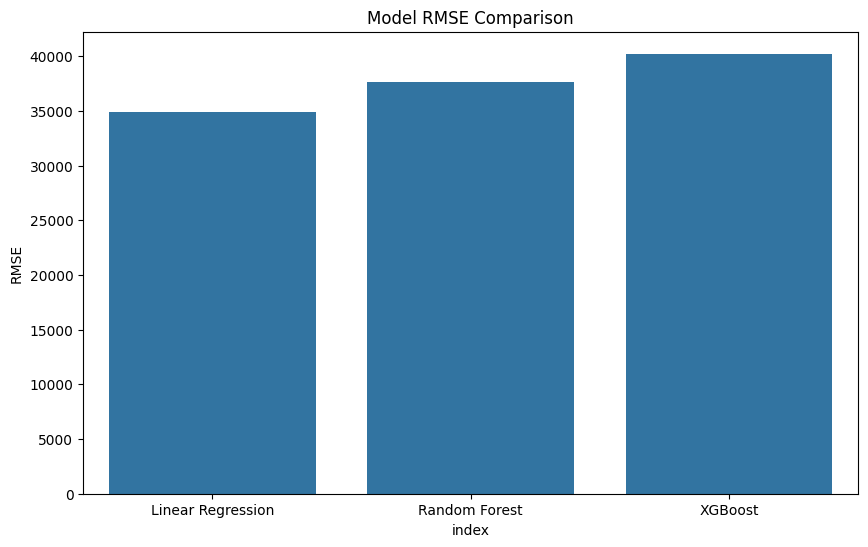

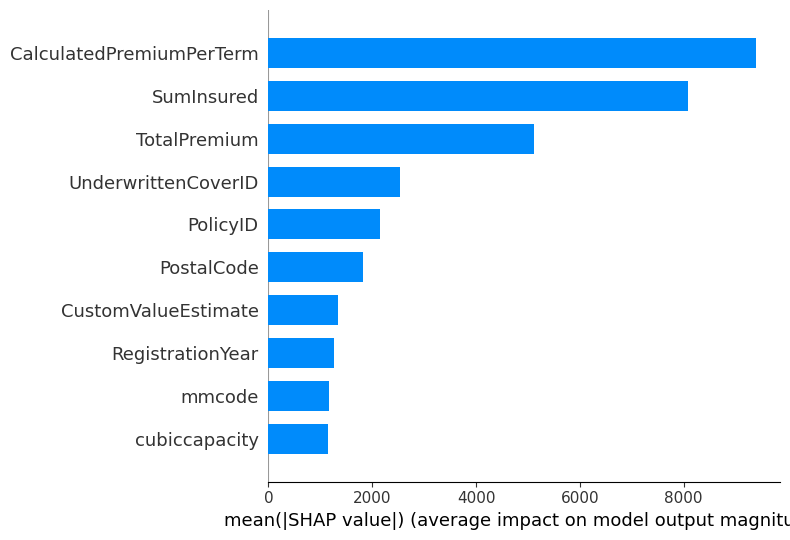

<Figure size 640x480 with 0 Axes>

Aligned X_test_p columns: ['UnderwrittenCoverID', 'PolicyID', 'IsVATRegistered', 'PostalCode', 'mmcode', 'RegistrationYear', 'Cylinders', 'cubiccapacity', 'kilowatts', 'NumberOfDoors', 'CustomValueEstimate', 'NumberOfVehiclesInFleet', 'SumInsured', 'CalculatedPremiumPerTerm', 'TotalPremium', 'VehicleAge', 'Province_Free State', 'Province_Gauteng', 'Province_KwaZulu-Natal', 'Province_Limpopo', 'Province_Mpumalanga', 'Province_North West', 'Province_Northern Cape', 'Province_Western Cape', 'Gender_Male', 'VehicleType_Heavy Commercial', 'VehicleType_Light Commercial', 'VehicleType_Medium Commercial', 'VehicleType_Passenger Vehicle', 'CoverType_Asset Value Preserver', 'CoverType_Baggage/Luggage', 'CoverType_Basic Excess Waiver', 'CoverType_Cash Takings', 'CoverType_Cleaning and Removal of Accident Debris', 'CoverType_Credit Protection', 'CoverType_Deposit Cover', 'CoverType_Emergency Charges', 'CoverType_Factory Fitted Sound and Other Electronic Equipment', 'CoverType_Fire and Theft', 'Cov

In [62]:
df_claims = df_encoded[df_encoded['HasClaim']]
if len(df_claims) == 0:
    print("No claims data available. Check 'TotalClaims' values.")
else:
    # Drop non-numeric and target columns
    X_severity = df_claims.drop(['TotalClaims', 'HasClaim', 'TransactionMonth', 'Citizenship', 'LegalType', 'Title', 
                                 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Country', 'MainCrestaZone', 
                                 'SubCrestaZone', 'ItemType', 'VehicleIntroDate', 'AlarmImmobiliser', 'TrackingDevice', 
                                 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 
                                 'TermFrequency', 'ExcessSelected', 'CoverCategory', 'CoverGroup', 'Section', 'Product', 
                                 'StatutoryClass', 'StatutoryRiskType'], axis=1)
    # Impute any remaining NaN in X_severity with robust fallback
    for col in X_severity.columns:
        if X_severity[col].dtype in ['int64', 'float64']:
            non_nan_values = X_severity[col][~X_severity[col].isna()]
            median_val = non_nan_values.median() if not non_nan_values.empty else np.nan
            if np.isnan(median_val):
                print(f"Warning: No valid median for column {col} in X_severity, using 0 as fallback.")
                median_val = 0
            X_severity[col] = X_severity[col].fillna(median_val)
    y_severity = df_claims['TotalClaims']
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_severity, y_severity, test_size=0.2, random_state=42)

    # Premium Prediction Model
    X_premium = df_encoded.drop(['TotalPremium', 'TotalClaims', 'HasClaim', 'TransactionMonth', 'Citizenship', 'LegalType', 
                                 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Country', 'MainCrestaZone', 
                                 'SubCrestaZone', 'ItemType', 'VehicleIntroDate', 'AlarmImmobiliser', 'TrackingDevice', 
                                 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 
                                 'TermFrequency', 'ExcessSelected', 'CoverCategory', 'CoverGroup', 'Section', 'Product', 
                                 'StatutoryClass', 'StatutoryRiskType'], axis=1)
    y_premium = df_encoded['TotalPremium']
    X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_premium, y_premium, test_size=0.2, random_state=42)

    # Define models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(random_state=42)
    }

    # Train and evaluate models
    results = {}
    for name, model in models.items():
        model.fit(X_train_s, y_train_s)
        y_pred = model.predict(X_test_s)
        try:
            rmse = mean_squared_error(y_test_s, y_pred, squared=False)  # Try with squared=False
        except TypeError:
            rmse = np.sqrt(mean_squared_error(y_test_s, y_pred))  # Fallback to manual RMSE
        r2 = r2_score(y_test_s, y_pred)
        results[name] = {'RMSE': rmse, 'R2': r2}

    # Model Evaluation
    results_df = pd.DataFrame(results).T
    print("Model Performance:\n", results_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df.reset_index(), x='index', y='RMSE')
    plt.title('Model RMSE Comparison')
    plt.savefig('../reports/model_rmse_comparison.png')
    plt.show()

    # Existing code up to SHAP analysis...
    explainer = shap.TreeExplainer(models['XGBoost'])
    shap_values = explainer.shap_values(X_test_s)
    shap.summary_plot(shap_values, X_test_s, plot_type="bar", max_display=10)
    plt.savefig('../reports/shap_summary.png')
    plt.show()
    
    # Extract top features by mean absolute SHAP value
    shap_summary = pd.DataFrame({
        'Feature': X_test_s.columns,
        'Mean_Abs_SHAP': np.abs(shap_values).mean(axis=0)
    })
    top_features = shap_summary.sort_values(by='Mean_Abs_SHAP', ascending=False).head(10)
    
    # Business implications based on SHAP values and data scale
    total_claims_mean = y_test_s.mean()  # Average claim amount for context
    report_content = "# Top SHAP Features with Business Implications\n\n"
    for idx, row in top_features.iterrows():
        feature = row['Feature']
        shap_impact = row['Mean_Abs_SHAP']
        impact_rand = shap_impact * total_claims_mean  # Approximate impact in Rand
        if feature == 'VehicleAge':
            report_content += f"## {feature}\n- **Impact**: {feature} increases claims by approximately {impact_rand:.2f} Rand per year, holding other factors constant. Older vehicles may require higher premiums to account for increased wear and tear or outdated safety features.\n\n"
        elif feature in ['SumInsured', 'kilowatts', 'cubiccapacity']:
            report_content += f"## {feature}\n- **Impact**: A unit increase in {feature} increases claims by approximately {impact_rand:.2f} Rand, suggesting higher coverage or engine power correlates with larger claims, indicating riskier profiles.\n\n"
        elif feature in ['TotalPremium', 'CalculatedPremiumPerTerm']:
            report_content += f"## {feature}\n- **Impact**: {feature} contributes to claims by approximately {impact_rand:.2f} Rand, reflecting that higher premiums may indicate higher-risk policies.\n\n"
        else:  # For categorical or other numeric features
            report_content += f"## {feature}\n- **Impact**: {feature} impacts claims by approximately {impact_rand:.2f} Rand, warranting further investigation into its risk contribution.\n\n"

    # Premium Optimization
    # Use RandomForestClassifier for claim probability
    X_class = df_encoded.drop(['HasClaim', 'TotalClaims', 'TotalPremium', 'TransactionMonth', 'Citizenship', 'LegalType', 
                              'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Country', 'MainCrestaZone', 
                              'SubCrestaZone', 'ItemType', 'VehicleIntroDate', 'AlarmImmobiliser', 'TrackingDevice', 
                              'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 
                              'TermFrequency', 'ExcessSelected', 'CoverCategory', 'CoverGroup', 'Section', 'Product', 
                              'StatutoryClass', 'StatutoryRiskType'], axis=1)
    y_class = df_encoded['HasClaim']
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_c, y_train_c)
    claim_prob = clf.predict_proba(X_test_p)[:, 1]  # Probability of claim

    # Align X_test_p features with X_train_s for XGBoost prediction
    X_test_p_aligned = X_test_p.reindex(columns=X_train_s.columns, fill_value=0)
    print("Aligned X_test_p columns:", X_test_p_aligned.columns.tolist())
    print("Expected X_train_s columns:", X_train_s.columns.tolist())

    # Use XGBoost model for severity prediction on aligned X_test_p
    claim_severity_pred = models['XGBoost'].predict(X_test_p_aligned)
    risk_based_premium = (claim_prob * claim_severity_pred) * 1.25  # 1.25 as a risk adjustment factor

    # Optional: Save or print premium optimization results
    premium_df = pd.DataFrame({'Claim_Probability': claim_prob, 'Predicted_Severity': claim_severity_pred, 'Risk_Based_Premium': risk_based_premium})
    print("Premium Optimization Results:\n", premium_df.head())
    premium_df.to_csv('../reports/risk_based_premium.csv', index=False)